In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import cv2
from glob import glob
import utils

# Data paths
DATA_PATH = None  # Will be set by setup_data function

In [2]:
def setup_data():
    """Set up the data path based on environment."""
    global DATA_PATH
    
    # Check if we're in Colab
    try:
        import google.colab
        from google.colab import drive
        
        # Mount Drive if not already mounted
        if not os.path.exists('/content/drive'):
            drive.mount('/content/drive')
        
        # Ask for path to project folder
        print("Enter path to the 281_final_project_data folder in Drive (e.g., /content/drive/MyDrive/281_final_project_data):")
        project_path = input()
        
        # Set the data path to the basic folder within the project
        DATA_PATH = os.path.join(project_path, "basic")
            
    except ImportError:
        # Not in Colab, download the data if needed
        download_path = "./281_final_project_data"
        
        # Check if data already exists
        if os.path.exists(download_path) and os.path.exists(os.path.join(download_path, "basic")):
            print(f"Using existing data in {download_path}/basic")
        else:
            print("Download data 281_final_project_data folder from Google Drive.")
        
        # Set the data path to the basic folder within the downloaded project
        DATA_PATH = os.path.join(download_path, "basic")


In [3]:
# Load images function
def load_data(directory):
    
    # First, ensure the data is available
    setup_data()
    path_to_data = DATA_PATH
    
    # load text file with image labels as a dictionary
    labels = pd.read_csv(os.path.join(path_to_data, "EmoLabel/list_patition_label.txt"), sep=" ", header=None)
    labels = dict(zip(labels[0], labels[1]))
    
    # update path_to_data
    path_to_data = os.path.join(path_to_data, "Image", directory)

    train_img = []
    train_labels = []
    test_img = []
    test_labels = []
    
    for file in os.listdir(path_to_data):
        image_path = os.path.join(path_to_data, file)
        image = load_img(image_path)
        img_arr = img_to_array(image, dtype=int)
        if directory == "aligned":
            label = labels[file.replace("_aligned", "")]
        else:
            label = labels[file]
        if "train" in file:
            train_img.append(img_arr)
            train_labels.append(label)
        else:
            test_img.append(img_arr)
            test_labels.append(label)

    train_labels = np.array(train_labels, dtype=int)
    test_labels = np.array(test_labels, dtype=int)
    
    if directory == "aligned":
        train_img = np.array(train_img)
        test_img = np.array(test_img)

        # Apply random shuffling to training examples.
        np.random.seed(0)
        indices = np.arange(train_img.shape[0])
        shuffled_indices = np.random.permutation(indices)
        train_img = train_img[shuffled_indices]
        train_labels = train_labels[shuffled_indices]

    return train_img, train_labels, test_img, test_labels

In [4]:
# Load label names
label_names_dict = {1: 'surprise', 2: 'fear', 3: 'disgust', 4: 'happiness', 5: 'sadness', 6: 'anger', 7: 'neutral'}

# Images are loaded as ints from 0 to 255
# Load training images and labels (original)
# Note: Loads images as a regular list since images are all different sizes. Labels are numpy array. 
# If loading originals, they will require further processing and shuffling. 
#train_img_org, train_labels_org, test_img_org, test_labels_org = load_data(DATA_PATH, "original")

# Load training images and labels (aligned)
# Converts images to numpy array since images are 100x100 and shuffles them. Labels are numpy array. 
train_img_aligned, train_labels_aligned, test_img_aligned, test_labels_aligned = load_data("aligned")


Using existing data in ./281_final_project_data/basic


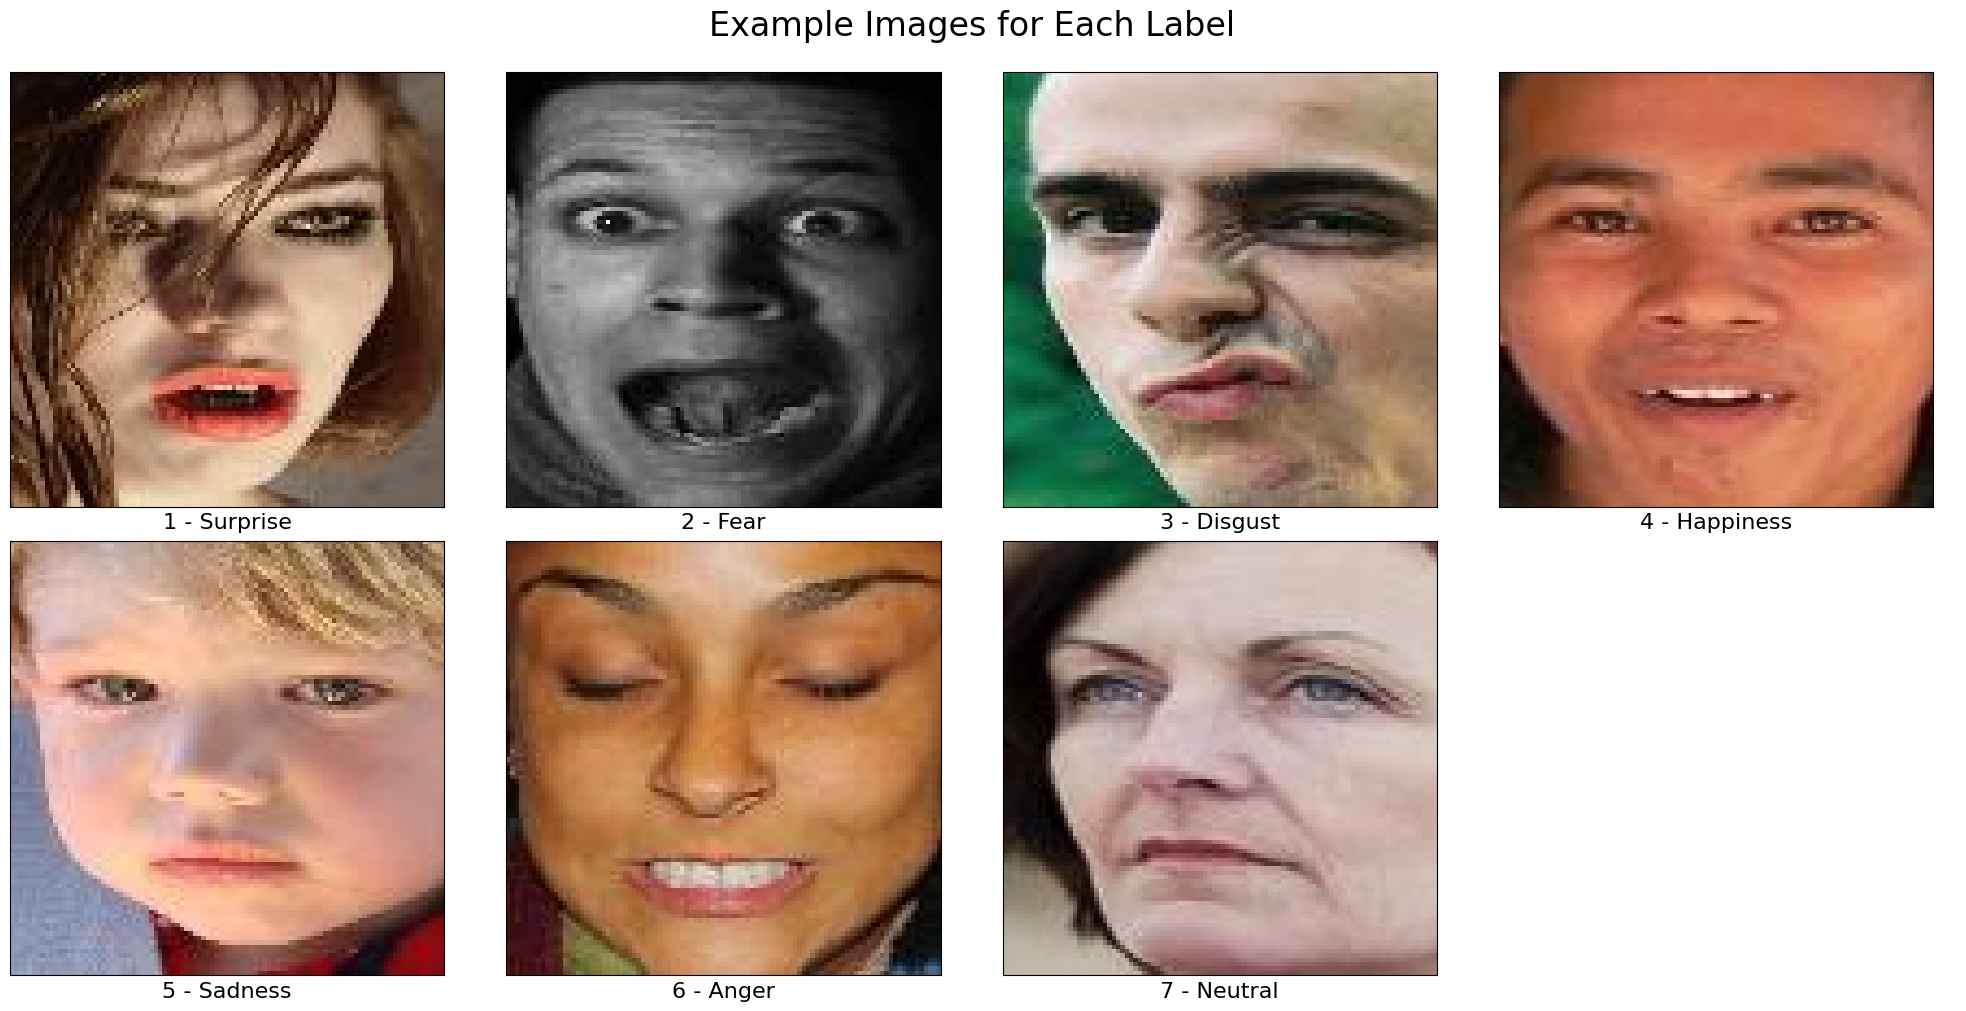

In [5]:
# Display images in 2 rows: 4 on top, 3 on bottom
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Example Images for Each Label', fontsize=24, y=1)

unique, indices = np.unique(train_labels_aligned, return_index=True)

pics = []
for idx, num in enumerate(indices):
    pics.append(train_img_aligned[num]) 

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Plot images
for i in range(8): 
    if i < 7:  
        axes_flat[i].imshow(pics[i])  
        axes_flat[i].tick_params(
            axis='both',
            which='both',
            bottom=False,
            top=False,
            left=False,
            labelbottom=False,
            labelleft=False,
            grid_alpha=0)
        axes_flat[i].set_xlabel(str(unique[i]) + " - " + label_names_dict[unique[i]].title(), fontsize=16)
    else:  # Turn off the last unused spot
        axes_flat[i].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

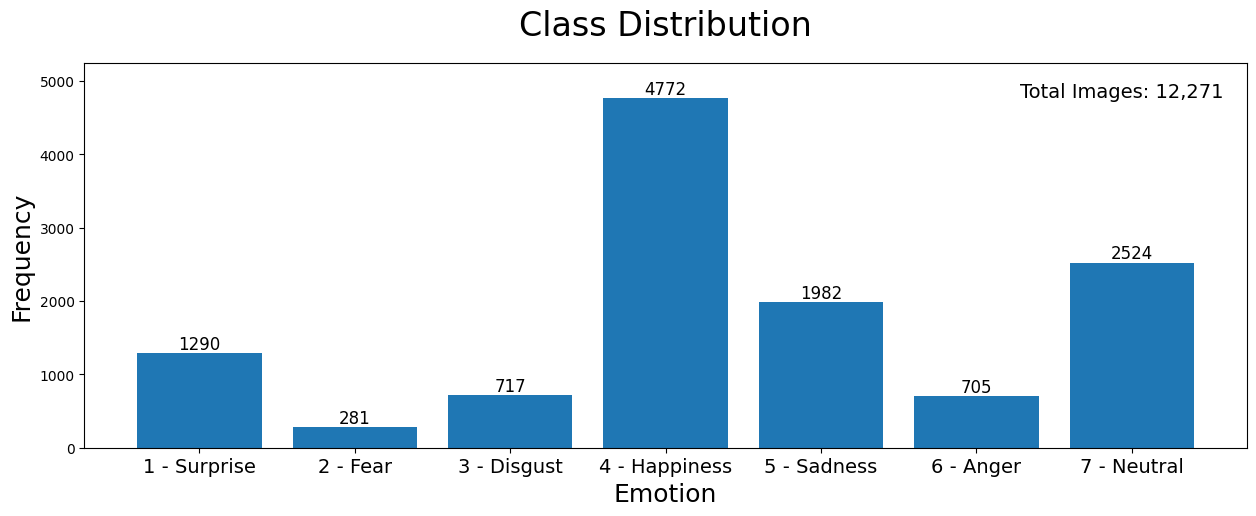

In [6]:
# Find unique value counts
unique, counts = np.unique(train_labels_aligned, return_counts=True)
classes = [str(num) + " - " + label_names_dict[num].title() for num in unique]
total_count = sum(counts)

# Create plot
plt.figure(figsize=(15, 5))
bars = plt.bar(range(len(counts)), counts)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12)

# Label/title plot
plt.title("Class Distribution", fontsize=24, y=1.05)
plt.xlabel("Emotion", fontsize=18)
plt.xticks(np.arange(len(counts)), classes, fontsize=14)
plt.ylabel("Frequency", fontsize=18)
plt.ylim(0, max(counts) * 1.1)
# Add total count as text annotation in upper right
plt.text(0.98, 0.95, f'Total Images: {total_count:,}', 
         transform=plt.gca().transAxes,
         ha='right', va='top',
         fontsize=14)

# Render plot
plt.show()

## Noise Reduction

In [7]:
# Function to apply noise reduction
def reduce_noise(images, strength=1):
      # Convert to uint8 if needed (required for OpenCV functions)
    orig_dtype = images.dtype
    if orig_dtype != np.uint8:
        # Scale if needed based on data range
        if orig_dtype == np.float32 or orig_dtype == np.float64:
            if images.max() <= 1.0:
                images = (images * 255).astype(np.uint8)
            else:
                images = images.astype(np.uint8)
        else:
            images = images.astype(np.uint8)
    
    processed_images = np.zeros_like(images)
    
    h_luminance = max(2, strength*3)  
    h_color = max(2, strength*3)      
    search_window = 21                
    template_window = 7 
    # Apply the selected noise reduction method to each image
    for i in range(images.shape[0]):
        processed_images[i] = cv2.fastNlMeansDenoisingColored(
            images[i], None, h_luminance, h_color, template_window, search_window)
    
    # Convert back to original dtype if needed
    if orig_dtype != np.uint8:
        if orig_dtype == np.float32 or orig_dtype == np.float64:
            if images.max() <= 1.0:
                processed_images = processed_images.astype(np.float32) / 255.0
    
    return processed_images

# Function to visualize the noise reduction
def visualize_noise_reduction(original_images, processed_images, num_samples=3):
    # Select random samples to display
    indices = np.random.choice(range(len(original_images)), min(num_samples, len(original_images)), replace=False)
    
    # Create a figure with side-by-side comparisons
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    
    for i, idx in enumerate(indices):
        # Original image
        axes[i, 0].imshow(original_images[idx].astype(np.uint8))
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        # Processed image
        axes[i, 1].imshow(processed_images[idx].astype(np.uint8))
        axes[i, 1].set_title('Noise Reduced Image')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


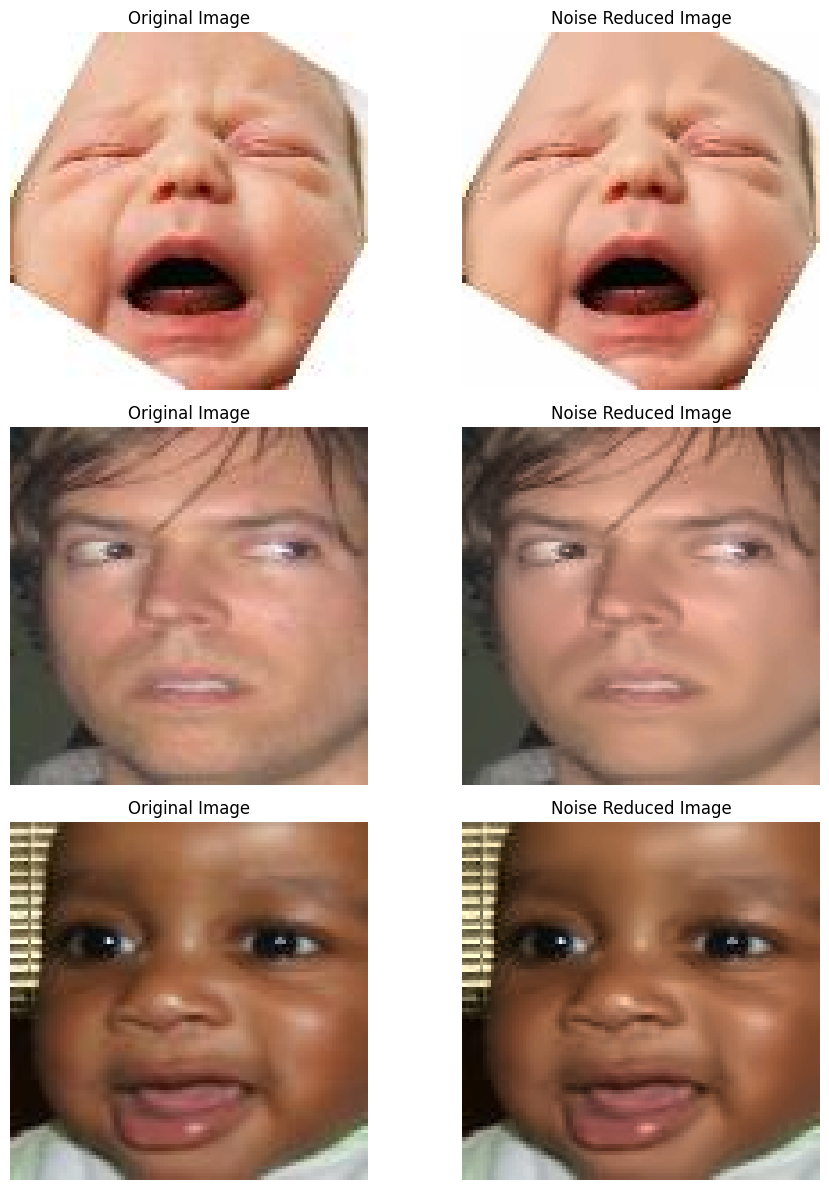

In [8]:
# Apply noise reduction
train_img_aligned_reduced = reduce_noise(train_img_aligned, strength=0.2)
visualize_noise_reduction(train_img_aligned, train_img_aligned_reduced , num_samples=3)

test_img_aligned_reduced = reduce_noise(test_img_aligned, strength=0.2)

In [9]:
# pickle prepreprocessed image arrays
utils.save_processed_data('preprocessed_data.pkl', train_img_aligned_reduced, train_labels_aligned, test_img_aligned_reduced, test_labels_aligned)

Data saved to ./281_final_project_data/preprocessed_data.pkl


### Adding Canny Edges to the Images

Canny edges can be added as a channel into the images (shape will then become (H, W, 4) instead of (H, W, 3)) and added as an input into the model, or be used in a pipeline to identify contours of facial landmarks (such as eyes, mouth, nose, etc), or sillhouettes, which can be included as feature statistics into the model.

The below function adds the canny filters into the image as an extra channel and outputs the manipulated image into a designated output folder. we can adjust this to output each image individually or some other format for our pipeline, depending on how it fits with the other feature extraction steps. 

### Template Matching statistics as Selected Features
One way to use template matching for feature engineering would be to have templates for each facial expression (e.g. raised eyebrows and open mouth for suprise, smile and thinner eyes for happy, etc). The below function gathers similarity metrics between an image and a template and could be implemented into a pipeline for us to gather these summary statistics across all facial expression templates. E.g. min_val, max_val, avg_score, std_score will be gathered for each facial expression and included in our feature set. 

One way of getting these templates is to use the training images and get an average face for each emotion class, then apply the canny detection pipeline to each template. This may add more information than a simple smiley face or frowning face. But if we do this should pay close attention to the test statistics as the templates could be overfit to the training data. We should also inspect those average faces to see if this seems feasible


In [ ]:


# processing all images and outputing list of canny edges
def process_images_with_canny(images, lower_threshold = 50, upper_threshold = 150): #suggested thresholds for detecting edges with canny
    """ Converts images to grayscale, enhances contrast, and applies Canny edge detection. outputs list of np.arrays"""

    processed_images = []
       
    for img in images:
        # grayscaling
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # equalizing histogram (contrast)
        img_eq = cv2.equalizeHist(img)
        
        # applying canny edge detection
        edges = cv2.Canny(img_eq, lower_threshold, upper_threshold)
        
        # appending to output list
        processed_images.append(edges)

    return processed_images
 
 
 
# getting an average face for each expression from our training data and applying canny filter 

def create_average_template(images, labels):
    """Creates an average face for all images for each emotion class, then outputting into a dict."""

    emotion_dict = {}
    unique_labels = set(labels)

    for lab in unique_labels:
        # Select all images with the current label
        float_images = [
            cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)).astype(np.float32)
            for img, label in zip(images, labels) if label == lab
        ]
    
        #getting average image of list
        avg_img = np.mean(float_images, axis=0)
    
        #applying canny filter
        avg_img = cv2.Canny(avg_img, 50, 150)
        
        # appending to dict
        emotion_dict[lab] = avg_img        
        

    return emotion_dict





# getting similarity statistics and outputing a vector of features for each emotion template 
def extract_expression_match_features_batch(images, labels, emotion_templates):
    """
    Takes a list of images and labels, and a dict of preprocessed emotion templates (as np.arrays).
    Returns:
        - A list of feature vectors (one per image).
        - A list of corresponding labels.
    """
    feature_matrix = []
    output_labels = []

    for img, label in zip(images, labels):
        # grayscale and equalizing imgs
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.equalizeHist(img)
        #applying canny edges
        img_edges = cv2.Canny(img, 50, 150)

        feature_vector = []

        #getting similarity metrics for each emotion template and adding as features 
        for emotion, template in emotion_templates.items():

            result = cv2.matchTemplate(img_edges, template, cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
            avg_score = np.mean(result)
            std_score = np.std(result)

            feature_vector.extend([max_val, avg_score, std_score])

        feature_matrix.append(np.array(feature_vector))
        output_labels.append(label)

    return feature_matrix, output_labels
